In [200]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

In [201]:
immo_df = pd.read_csv('data/immo_data.csv')
max_flaeche = np.percentile(immo_df['livingSpace'], 99.9)

zv_df = pd.read_csv('data/zwangsversteigerungen.csv')
#There are apartments available for free, as well as errors in the generated data. I will filter out apartments priced below €50,000.
wohnungen_df = zv_df[
    (zv_df['typ'] == 'Wohnung') & 
    (zv_df['verkehrswert'] >= 50000) & 
    (zv_df['flaeche'] <= max_flaeche) &
    (zv_df['raeume'] <= 10)
].copy()

immo_df = immo_df[
    # I will focus solely on apartments, defining the specific characteristics that qualify them for my analysis.
    # Additionally, only apartments that are realistically available for purchase are considered.
    (immo_df['yearConstructed'] >= wohnungen_df['baujahr'].min()) &
    (immo_df['baseRent'] <= np.percentile(immo_df['baseRent'], 99.9)) & # filter out > 4800
    (immo_df['livingSpace'] <= max_flaeche) & # filter out > 240m^2
    (immo_df['noRooms'] <= 10)
]
immo_df = immo_df[['regio1', 'balcony', 'baseRent', 'yearConstructed', 'noRooms', 'livingSpace', 'garden']]
immo_df = immo_df.dropna()
immo_df['regio1'] = immo_df['regio1'].str.replace('_', '-')

In [202]:
X = immo_df[['regio1', 'balcony', 'baseRent', 'yearConstructed', 'noRooms', 'livingSpace', 'garden']]
y = immo_df['baseRent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
preprocessor = ColumnTransformer(
    transformers=[
        ('regio1', OneHotEncoder(), ['regio1']),
        ('bool_cols', 'passthrough', ['balcony', 'garden']),
        ('num_cols', 'passthrough', ['yearConstructed', 'noRooms', 'livingSpace'])
    ]
)

best_model_filename = 'data/best_model.joblib'
if os.path.exists(best_model_filename):
    print("Load existing Model!")
    best_model = joblib.load(best_model_filename)
else:
    print("Start Training!")


    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])

    param_grid = [
        {
            'regressor': [LinearRegression()]
        },
        {
            'regressor': [SVR()],
            'regressor__kernel': ['rbf'],
            'regressor__C': [1, 10, 30],
            'regressor__epsilon': [0.1, 0.2]
        },
        {
            'regressor': [DecisionTreeRegressor(random_state=2024)],
            'regressor__max_depth': [5, 10, 15, 50],
            'regressor__min_samples_split': [2, 5, 10, 50]
        },
        {
            'regressor': [RandomForestRegressor(random_state=2024)],
            'regressor__n_estimators': [50, 100, 300],
            'regressor__max_depth': [10, 20]
        },
        {
            'regressor': [GradientBoostingRegressor(random_state=2024)],
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.1, 0.15]
        },
        {
            'regressor': [MLPRegressor(max_iter=1000, random_state=2024)],
            'regressor__hidden_layer_sizes': [(100, 50), (50, 50), (100, 50, 25, 50, 100)],
        },
        {
            'regressor': [XGBRegressor(random_state=2024)],
            'regressor__n_estimators': [300, 1000, 5000],
            'regressor__learning_rate': [0.01, 0.05, 0.1],
            'regressor__max_depth': [3, 6, 10],
            'regressor__subsample': [0.8, 1.0],
            'regressor__colsample_bytree': [0.8, 1.0]
        }
    ]

    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, param_grid, cv=7, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    best_model = grid_search.best_estimator_

    joblib.dump(best_model, best_model_filename)
    print(f"Best model saved as {best_model_filename}")

Load existing Model!


Mean Absolute Error: 130.02953808544206
Mean Squared Error: 46702.04883315902


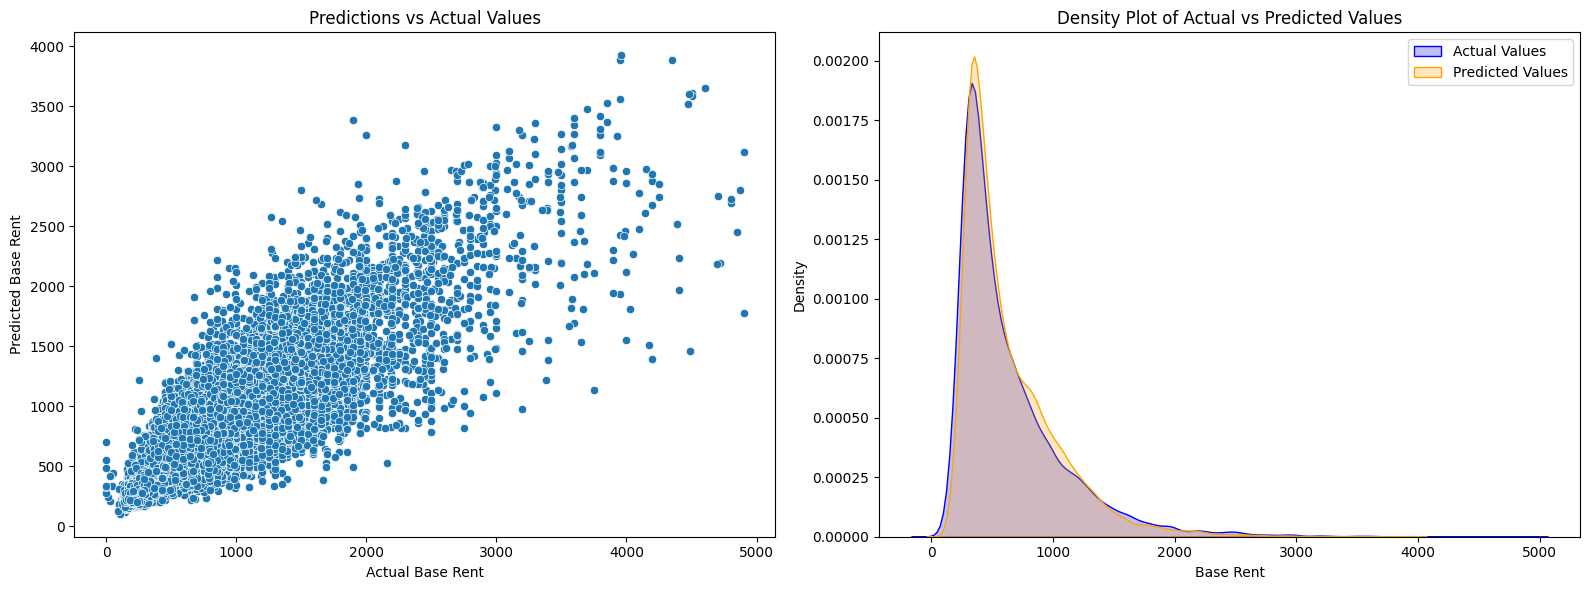

In [203]:
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

sns.scatterplot(x=y_test, y=y_pred, ax=axes[0])
axes[0].set_title("Predictions vs Actual Values")
axes[0].set_xlabel("Actual Base Rent")
axes[0].set_ylabel("Predicted Base Rent")

sns.kdeplot(y_test, label="Actual Values", color='blue', fill=True, ax=axes[1])
sns.kdeplot(y_pred, label="Predicted Values", color='orange', fill=True, ax=axes[1])
axes[1].set_title("Density Plot of Actual vs Predicted Values")
axes[1].set_xlabel("Base Rent")
axes[1].legend()

plt.tight_layout()
plt.show()

In [204]:
def fastest_profitable_apartment(df):
    df = df.copy()
    df['base_rent_months'] = df['verkehrswert'] / (df['predicted_rent'] * 0.9)
    df = df.sort_values(by='base_rent_months', ascending=True)
    return df

def fastest_profitable_apartment_with_loan(df, base_capital, additional_monthly_rate, interest_rate):
    """
    Calculate the total payment for a loan based on the provided parameters. 
    Parameters:
        df (pd.DataFrame): A DataFrame containing rental income and property costs for different properties.
        base_capital (float): The amount to be directly deducted from the property value (in euros).
        additional_monthly_rate (float): The additional monthly rate the user is willing to pay (in euros).
        interest_rate (float): The annual interest rate [0, 1].

    Returns:
        pd.DataFrame: A DataFrame with calculated total payments and other loan details.
    """
    df = df.copy()
    df['net_rent'] = df['predicted_rent'] * 0.9
    effective_monthly_payment_rate = df['net_rent'] + additional_monthly_rate
    credit_amount = df['verkehrswert'] - base_capital
    monthly_interest_rate = interest_rate / 12
    
    # Initialize columns for loan, monthly payment, loan duration, and total payment
    df['loan'] = credit_amount
    df['monthly_payment'] = effective_monthly_payment_rate
    
    if monthly_interest_rate == 0:
        # no interest case
        df['loan_duration_in_months'] = credit_amount / effective_monthly_payment_rate
    else:
        # Calculate loan duration (n) using the formula
        # R = (K * i * (1 + i)^n) / ((1 + i)^n - 1 ) 
        # n = ln(R / (R - K * i)) / ln(1 + i)
        # content inside log can be negative if interest rate is too high, columns are set to np.nan where this is the case
        numerator = np.log(df['monthly_payment'] / (df['monthly_payment'] - credit_amount * monthly_interest_rate))
        denominator = np.log(1 + monthly_interest_rate)
        df['loan_duration_in_months'] = numerator / denominator
    
    df.loc[df['loan_duration_in_months'] < 0, 'loan_duration_in_months'] = np.nan
    df['total_payment_for_loan'] = df['monthly_payment'] * df['loan_duration_in_months']
    df['total_money_spent'] = base_capital + df['total_payment_for_loan']
    
    # Earliest date when money would be even
    df['money_even'] = df['loan_duration_in_months'] + (additional_monthly_rate * df['loan_duration_in_months'] + base_capital) / df['net_rent']
    df = df.sort_values(by='money_even', ascending=True, na_position='last')
    return df

In [205]:
zv_predictions_df = wohnungen_df.copy()
zv_predictions_df = zv_predictions_df.rename(columns={
    'flaeche': 'livingSpace',
    'baujahr': 'yearConstructed',
    'raeume': 'noRooms',
    'bundesland_name': 'regio1',
    'balkon': 'balcony',
    'garten': 'garden'
})

features = ['regio1', 'balcony', 'garden', 'yearConstructed', 'noRooms', 'livingSpace']
X_new = zv_predictions_df[features]

X_train_preprocessed = preprocessor.fit_transform(X_train)
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
iterative_imputer.fit(X_train_preprocessed.toarray())  # Fit the imputer on the immo data

# Impute missing values in X_new after preprocessing
X_new_preprocessed = preprocessor.transform(X_new)
X_new_imputed = iterative_imputer.transform(X_new_preprocessed.toarray())

zv_predictions_df['noRooms'] = X_new_imputed[:, -2].astype(int)
zv_predictions_df['noRooms'] = zv_predictions_df['noRooms'].clip(lower=1, upper=10)

zv_predictions_df['yearConstructed'] = X_new_imputed[:, -3].astype(int)
zv_predictions_df['yearConstructed'] = zv_predictions_df['yearConstructed'].clip(lower=wohnungen_df['baujahr'].min(), upper=2024)

zv_predictions_df['predicted_rent'] = best_model.predict(zv_predictions_df)

wohnungen_df['imputed_raume'] = zv_predictions_df['noRooms']
wohnungen_df['imputed_baujahr'] = zv_predictions_df['yearConstructed']
wohnungen_df['predicted_rent'] = zv_predictions_df['predicted_rent']

C:\Users\Eric User\AppData\Local\Temp\ipykernel_20476\1049988483.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=rent_bins, data=wohnungen_df, palette="Blues_d", ax=axes[0])


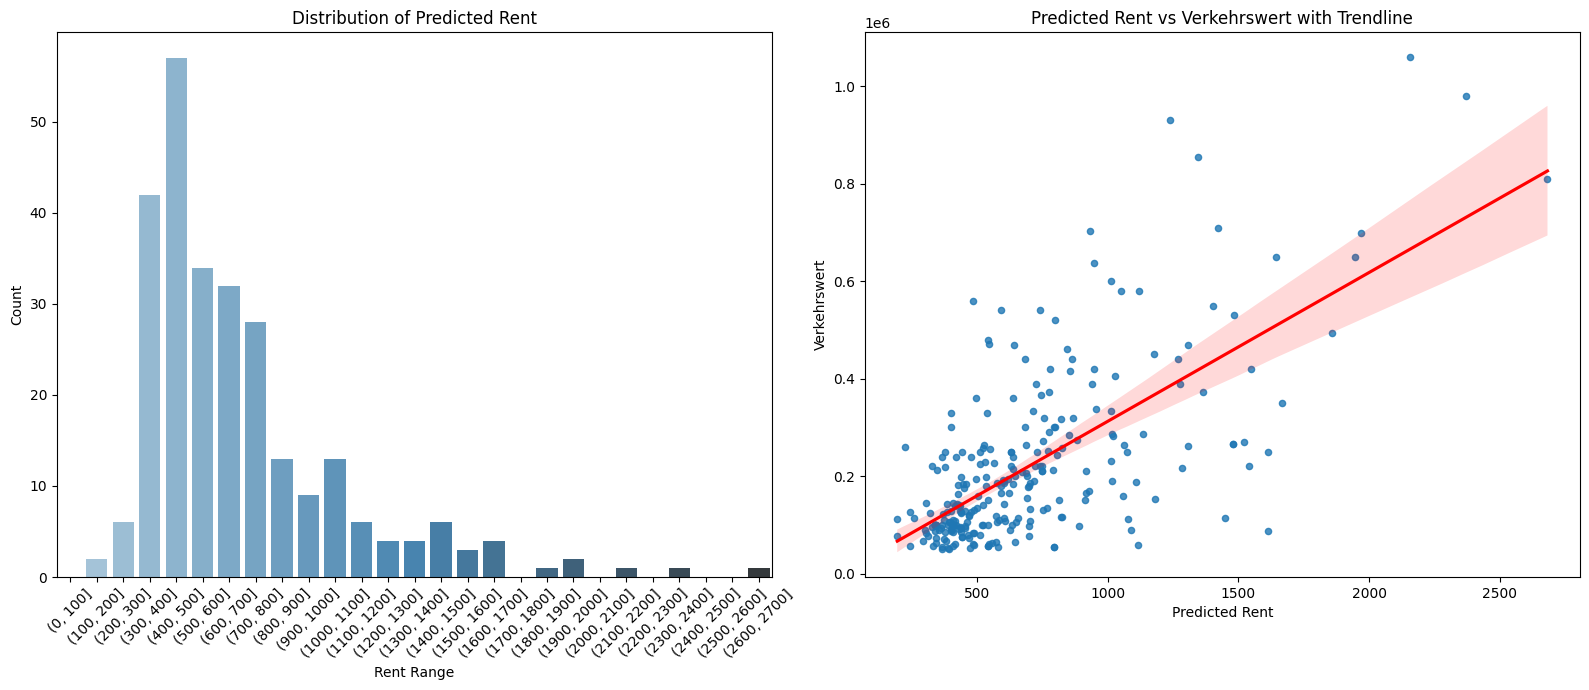

In [206]:
rent_bins = pd.cut(wohnungen_df['predicted_rent'], bins=range(0, int(wohnungen_df['predicted_rent'].max()) + 100, 100))

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Subplot 1: Bar chart for rent ranges
sns.countplot(x=rent_bins, data=wohnungen_df, palette="Blues_d", ax=axes[0])
axes[0].set_xticks(range(len(axes[0].get_xticklabels())))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Distribution of Predicted Rent')
axes[0].set_xlabel('Rent Range')
axes[0].set_ylabel('Count')

# Subplot 2: Scatter plot with trendline for predicted_rent vs verkehrswert
sns.regplot(x=wohnungen_df['predicted_rent'], y=wohnungen_df['verkehrswert'], scatter_kws={'s': 20}, line_kws={'color': 'red'}, ax=axes[1])
axes[1].set_title('Predicted Rent vs Verkehrswert with Trendline')
axes[1].set_xlabel('Predicted Rent')
axes[1].set_ylabel('Verkehrswert')

plt.tight_layout()
plt.show()

In [207]:
wohnungen_df_profitable = fastest_profitable_apartment(wohnungen_df)
wohnungen_df_profitable_with_loan = fastest_profitable_apartment_with_loan(wohnungen_df, 50000, 500, 0.07)

d:\Zeug\Unizeug\Master_DataScience\3.Semester\Urban Technologies\Project\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


C:\Users\Eric User\AppData\Local\Temp\ipykernel_20476\3657319614.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=no_loan_bins, data=wohnungen_df_profitable, palette="Blues_d", ax=axes[0])
C:\Users\Eric User\AppData\Local\Temp\ipykernel_20476\3657319614.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=loan_bins, data=wohnungen_df_profitable_with_loan, palette="Blues_d", ax=axes[1])


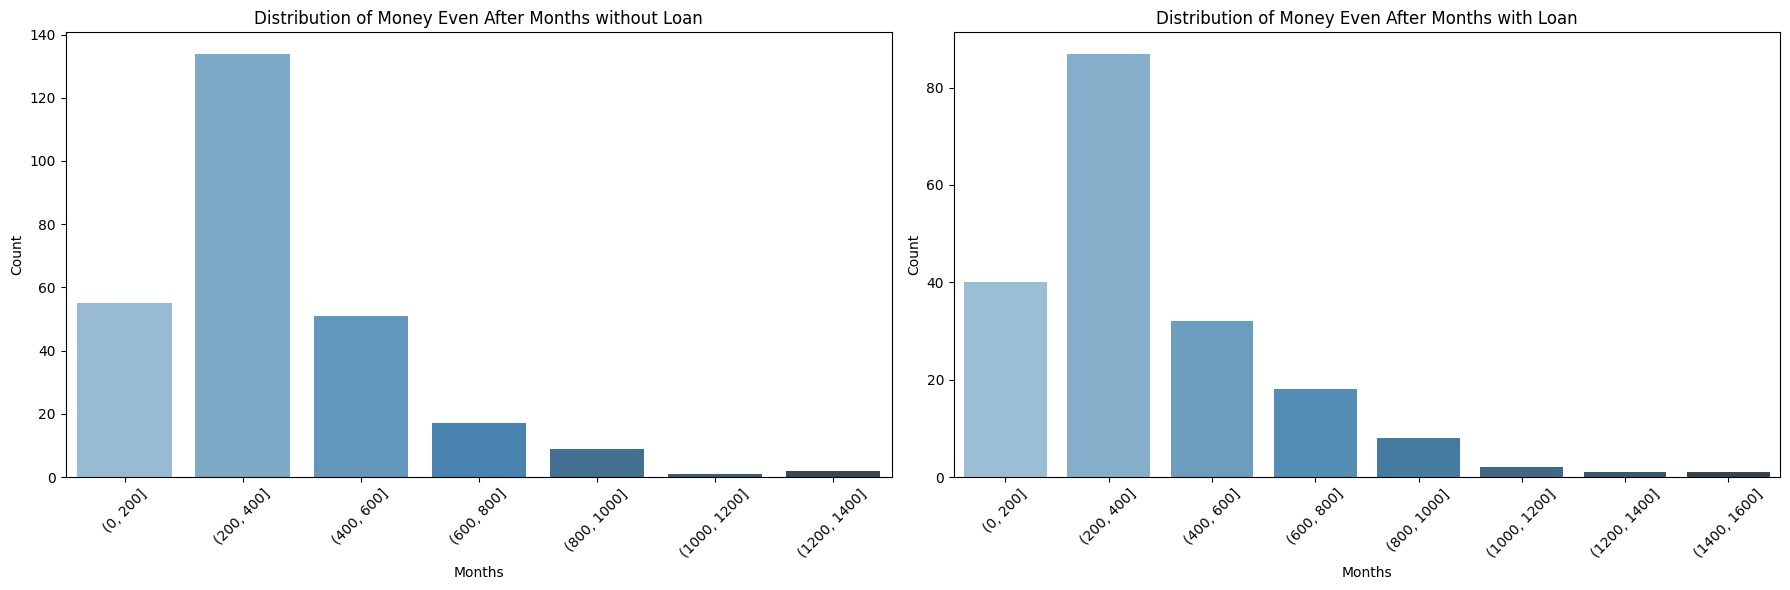

In [208]:
bin_width = 200
no_loan_bins = pd.cut(wohnungen_df_profitable['base_rent_months'],
                   bins=range(int(wohnungen_df_profitable['base_rent_months'].min()) // bin_width * bin_width,
                             int(wohnungen_df_profitable['base_rent_months'].max()) + bin_width,
                             bin_width))

loan_bins = pd.cut(wohnungen_df_profitable_with_loan['money_even'],
                    bins=range(int(wohnungen_df_profitable_with_loan['money_even'].min()) // bin_width * bin_width,
                              int(wohnungen_df_profitable_with_loan['money_even'].max()) + bin_width,
                              bin_width))

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Subplot 1: Bar chart for money even after months
sns.countplot(x=no_loan_bins, data=wohnungen_df_profitable, palette="Blues_d", ax=axes[0])
axes[0].set_xticks(range(len(axes[0].get_xticklabels())))
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_title('Distribution of Money Even After Months without Loan')
axes[0].set_xlabel('Months')
axes[0].set_ylabel('Count')

# Subplot 2: Bar chart for base_rent_months
sns.countplot(x=loan_bins, data=wohnungen_df_profitable_with_loan, palette="Blues_d", ax=axes[1])
axes[1].set_xticks(range(len(axes[1].get_xticklabels())))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_title('Distribution of Money Even After Months with Loan')
axes[1].set_xlabel('Months')
axes[1].set_ylabel('Count')

# At first glance, it may seem confusing that the range of months is longer without a loan, as a loan typically requires higher payments. 
# This is because the loan chart is truncated when we are unable to repay the loan at all.
plt.tight_layout()
plt.show()


In [209]:
wohnungen_df_profitable.head(3)

,foreclosurecase_link,flaeche,verkehrswert,typ,baujahr,raeume,raum_typen,balkon,garten,objekt_lage,aktenzeichen,termin,art_der_versteigerung,beschreibung,bundesland_name,imputed_raume,imputed_baujahr,predicted_rent,base_rent_months
2545,https://www.zvg-portal.de/index.php?button=sho...,114,58000,Wohnung,1895.0,0.0,NaN,False,False,Wohnungseigentumsrecht an zwei zum Treppenhaus...,0005 K 0121/ 2022,1739959200,Versteigerung im Wege der Zwangsvollstreckung,Laut Wertgutachten handelt es sich um das Wohn...,Nordrhein-Westfalen,1,1895,1115.611084,57.766052
190,https://www.zvg-portal.de/index.php?button=sho...,195,87600,Wohnung,1897.0,6.0,"Wohnzimmer,Küche,Badezimmer,Flur,Küche,Badezimmer",False,False,Eigentumswohnung (3 bis 4 Zimmer): Augustastr....,0031 K 0008/ 2023,1735891200,Versteigerung im Wege der Zwangsvollstreckung,Laut Wertgutachten: Eigentumswohnung im Dachge...,Nordrhein-Westfalen,6,1897,1612.574951,60.358955
63,https://www.zvg-portal.de/index.php?button=sho...,31,55500,Wohnung,1900.0,4.0,"Wohnzimmer,Küche,Badezimmer,Flur",False,False,Eigentumswohnung (1 bis 2 Zimmer): Paretzer St...,0070 K 0034/ 2022,1740562200,Versteigerung im Wege der Zwangsvollstreckung,Eigentumswohnung Nr. 19 sowie dem Kellerraum N...,Berlin,4,1900,792.249878,77.837400


In [210]:
wohnungen_df_profitable_with_loan.head(3)

,foreclosurecase_link,flaeche,verkehrswert,typ,baujahr,raeume,raum_typen,balkon,garten,objekt_lage,...,imputed_raume,imputed_baujahr,predicted_rent,net_rent,loan,monthly_payment,loan_duration_in_months,total_payment_for_loan,total_money_spent,money_even
2545,https://www.zvg-portal.de/index.php?button=sho...,114,58000,Wohnung,1895.0,0.0,NaN,False,False,Wohnungseigentumsrecht an zwei zum Treppenhaus...,...,1,1895,1115.611084,1004.049927,8000,1504.049927,5.418981,8150.417814,58150.417814,57.915863
190,https://www.zvg-portal.de/index.php?button=sho...,195,87600,Wohnung,1897.0,6.0,"Wohnzimmer,Küche,Badezimmer,Flur,Küche,Badezimmer",False,False,Eigentumswohnung (3 bis 4 Zimmer): Augustastr....,...,6,1897,1612.574951,1451.317383,37600,1951.317383,20.500211,40002.417494,90002.417494,62.014290
63,https://www.zvg-portal.de/index.php?button=sho...,31,55500,Wohnung,1900.0,4.0,"Wohnzimmer,Küche,Badezimmer,Flur",False,False,Eigentumswohnung (1 bis 2 Zimmer): Paretzer St...,...,4,1900,792.249878,713.024841,5500,1213.024902,4.608549,5590.285204,55590.285204,77.964023


In [211]:
diff_indices = []
for idx, (link1, link2) in enumerate(zip(wohnungen_df_profitable['foreclosurecase_link'], 
                                          wohnungen_df_profitable_with_loan['foreclosurecase_link'])):
    if link1 != link2:
        diff_indices.append(idx)

In [212]:
wohnungen_df_profitable.iloc[diff_indices[:3]].head(3)

,foreclosurecase_link,flaeche,verkehrswert,typ,baujahr,raeume,raum_typen,balkon,garten,objekt_lage,aktenzeichen,termin,art_der_versteigerung,beschreibung,bundesland_name,imputed_raume,imputed_baujahr,predicted_rent,base_rent_months
26,https://www.zvg-portal.de/index.php?button=sho...,48,111000,Wohnung,1877.0,5.0,"Flur,Badezimmer,Küche,Wohnzimmer,Schlafzimmer",True,False,"s. Beschreibung: Seifartshofstraße 36, 96450 ...",0001 K 0080/ 2023,1738047600,Zwangsversteigerung zum Zwecke der Aufhebung d...,Objektbeschreibung/Lage (lt Angabe d. Sachvers...,Bayern,5,1877,1075.432495,114.682546
62,https://www.zvg-portal.de/index.php?button=sho...,31,56000,Wohnung,1900.0,1.0,"Wohnzimmer,Küche,Badezimmer,Flur",False,False,Eigentumswohnung (1 bis 2 Zimmer): Paretzer St...,0070 K 0033/ 2022,1740556800,Versteigerung im Wege der Zwangsvollstreckung,Eigentumswohnung Nr. 17 sowie dem Kellerraum N...,Berlin,1,1900,540.673523,115.082799
109,https://www.zvg-portal.de/index.php?button=sho...,44,60000,Wohnung,1995.0,3.0,"Küche,Badezimmer",False,False,Eigentumswohnung (1 bis 2 Zimmer): Im Heienbac...,0004 K 0042/ 2023,1737532800,Versteigerung im Wege der Zwangsvollstreckung,Eigentumswohnung (2 Z/K/B) im DG eines Mehrfam...,Hessen,3,1995,545.539246,122.203246


In [213]:
wohnungen_df_profitable_with_loan.iloc[diff_indices[:3]].head(3)

,foreclosurecase_link,flaeche,verkehrswert,typ,baujahr,raeume,raum_typen,balkon,garten,objekt_lage,...,imputed_raume,imputed_baujahr,predicted_rent,net_rent,loan,monthly_payment,loan_duration_in_months,total_payment_for_loan,total_money_spent,money_even
61,https://www.zvg-portal.de/index.php?button=sho...,31,56000,Wohnung,1900.0,1.0,"Wohnzimmer,Küche,Badezimmer,Flur",False,False,Eigentumswohnung (1 bis 2 Zimmer): Paretzer St...,...,1,1900,540.673523,486.606171,6000,986.606201,6.209987,6126.812016,56126.812016,115.343403
109,https://www.zvg-portal.de/index.php?button=sho...,44,60000,Wohnung,1995.0,3.0,"Küche,Badezimmer",False,False,Eigentumswohnung (1 bis 2 Zimmer): Im Heienbac...,...,3,1995,545.539246,490.985321,10000,990.985352,10.430463,10336.436111,60336.436111,122.888472
26,https://www.zvg-portal.de/index.php?button=sho...,48,111000,Wohnung,1877.0,5.0,"Flur,Badezimmer,Küche,Wohnzimmer,Schlafzimmer",True,False,"s. Beschreibung: Seifartshofstraße 36, 96450 ...",...,5,1877,1075.432495,967.889221,61000,1467.889160,47.729820,70062.085488,120062.085488,124.045279
